/home/vk5/.local/lib/python2.7/site-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


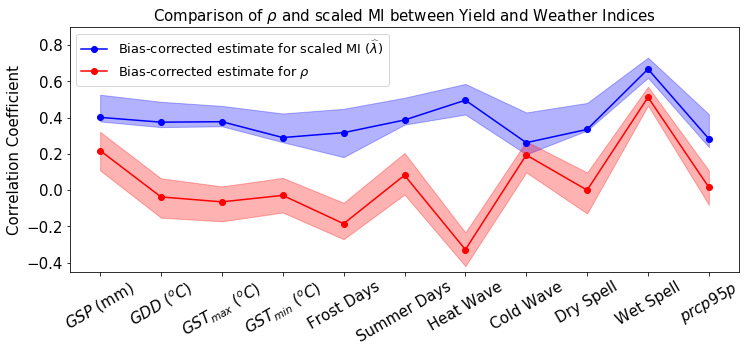

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log, sqrt, exp
from scipy.stats import gaussian_kde
from numpy import random

INDICES = pd.read_csv('combined_indices.csv')
YIELD = pd.read_csv('yield.csv')
indices = INDICES.iloc[:,2:13]
corn_yield = YIELD.iloc[:,2]

# Fit PDF with best bandwith and get probabilities
def estimate_prob(arr):
   arr1 = arr[:,0]
   arr1 = arr1.reshape(1, -1)
   arr2 = arr[:,1]
   arr2 = arr2.reshape(1, -1)

   gkde=gaussian_kde(arr1, bw_method='scott')
   kdepdf = gkde.evaluate(arr1)
   yield_prob = np.reshape(kdepdf.T, arr1.shape)

   gkde=gaussian_kde(arr2, bw_method='scott') 
   kdepdf = gkde.evaluate(arr2)
   index_prob = np.reshape(kdepdf.T, arr2.shape)

   positions = np.vstack([arr1.ravel(), arr2.ravel()])
   values = np.vstack([arr1, arr2])
   kernel = gaussian_kde(values, bw_method='scott')
   combined_prob = np.reshape(kernel(positions).T, arr1.shape)

   new_arr = np.concatenate((yield_prob,index_prob,combined_prob), axis=0)
   return(new_arr)

def calculate_MI(prob):
    mi=0
    for i in range(0, prob.shape[1]):
        ratio_num = prob[2,i]
        ratio_denom1 = prob[1,i]
        ratio_denom2 = prob[0,i]
        ratio = (ratio_num/(ratio_denom1*ratio_denom2))
        log_ratio = log(ratio,2)
        mi = mi + log_ratio
    mi = mi/prob.shape[1]
    return(mi)

def scaled_MI(mi):
    s_mi = sqrt(1 - exp(-2*mi))
    return(s_mi)

def master_func(arr):
    prob = estimate_prob(arr)
    mi = calculate_MI(prob)
    s_mi = scaled_MI(mi)
    return(s_mi)

full_list = list(range(0,indices.shape[0]))
prop = int(0.8*len(full_list))
fig, ax =plt.subplots(figsize=(12,5))

unbiased_MI=[]
p95_MI=[]
p5_MI=[]
unbiased_PC=[]
p95_PC=[]
p5_PC=[]

for i in range(0, len(indices.columns)):
    arr = pd.DataFrame.as_matrix(pd.concat([corn_yield,indices.iloc[:,i]], axis=1))
    full_data_MI = master_func(arr)
    full_data_PC = np.corrcoef(arr[:,0],arr[:,1])[0,1] 
    MI=[]
    PC=[]
    for j in range(0, 100):
        jack_list = list(np.sort(random.choice(full_list, prop, replace=False)))
        arr_sub = arr[jack_list,:]
        MI.append(master_func(arr_sub))
        PC.append(np.corrcoef(arr_sub[:,0],arr_sub[:,1])[0,1])
    jack_mean_MI = np.mean(MI)
    jack_mean_PC = np.mean(PC)
    unbiased_MI.append(2*full_data_MI - jack_mean_MI)
    p95_MI.append(np.percentile(MI, 95))
    p5_MI.append(np.percentile(MI, 5))
    unbiased_PC.append(2*full_data_PC - jack_mean_PC)
    p95_PC.append(np.percentile(PC, 95))
    p5_PC.append(np.percentile(PC, 5))
    
ax.plot(unbiased_MI,'-bo',label="Bias-corrected estimate for scaled MI " + "($\widehat{\lambda}$)")
lab = 'Bias-corrected estimate for ' + r'$\rho$'
ax.plot(unbiased_PC,'-ro',label= lab)
plt.ylabel('Correlation Coefficient', fontsize=15)
title = "Comparison of " + r'$\rho$' " and scaled MI between Yield and Weather Indices" 
plt.title(title, fontsize=15)
locs = [i for i in range(0, len(list(indices.columns)))]
lab = ["$GSP$ (mm)", "$GDD$ ($^oC$)", "$GST_{max}$ ($^oC$)", "$GST_{min}$ ($^oC$)", "Frost Days", "Summer Days",
      "Heat Wave", "Cold Wave", "Dry Spell", "Wet Spell", "$prcp95p$"]
plt.xticks(locs, lab, rotation=30)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.fill_between(locs, np.asarray(p5_MI), np.asarray(p95_MI), where= np.asarray(p95_MI)>= np.asarray(p5_MI), color='blue', interpolate=True, alpha=0.3)
ax.fill_between(locs, np.asarray(p5_PC), np.asarray(p95_PC), where= np.asarray(p95_PC)>= np.asarray(p5_PC), color='red', interpolate=True, alpha=0.3)
plt.legend(fontsize=13)
plt.ylim(-0.45,0.9)
plt.subplots_adjust(bottom=0.2)
plt.savefig("MI_vs_rho.png")